# 3D Viewer on Medical Data

## Initialization

Enable the interactive matplotlib mode and import relative libs.

In [60]:
import matplotlib.pyplot as plt
from skimage import data

%matplotlib notebook

Examples on display normal images with Matplotlib's `imshow`.

<IPython.core.display.Javascript object>


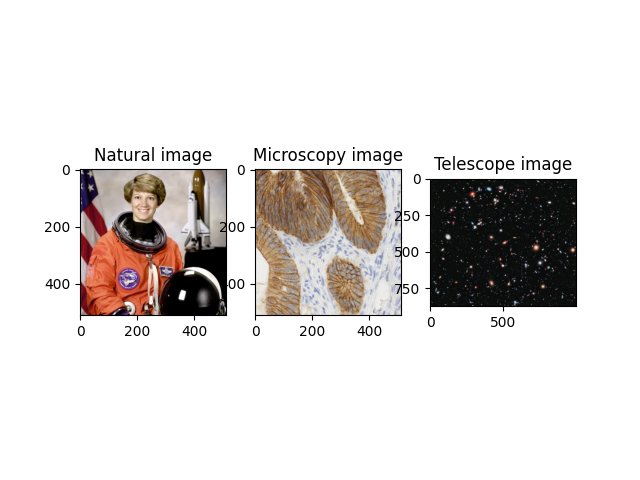

Text(0.5, 1.0, 'Telescope image')

In [61]:
# get normal 2D data

astronaut = data.astronaut()
ihc = data.immunohistochemistry()
hubble = data.hubble_deep_field()

# Initialize the subplot panels side by side
fig, ax = plt.subplots(nrows=1, ncols=3)

# Show images
ax[0].imshow(astronaut)
ax[0].set_title("Natural image")
ax[1].imshow(ihc)
ax[1].set_title("Microscopy image")
ax[2].imshow(hubble)
ax[2].set_title("Telescope image")

Some images are 3D, in that they have an additional _depth_ dimension (z, or planes). These include MRI and serial section transmission electron microscopy (ssTEM), in which a sample is thinly sliced, and each of the slices is imaged separately.

To view such images in matplotlib, we have to choose a slice, and display only that slice.

## Getting the Data

We’re going to download a dataset described in Buchel and Friston, [Cortical Interactions Evaluated with Structural Equation Modelling and fMRI (1997)](https://pubmed.ncbi.nlm.nih.gov/9408041/).

First we download the data:

In [62]:
import os
from urllib.request import urlretrieve

url = "http://www.fil.ion.ucl.ac.uk/spm/download/data/attention/attention.zip"
if not (os.path.exists('./data/attention.zip')):
    fn, info = urlretrieve(url, os.path.join('./data/', 'attention.zip'))

Then extract it from the `zip` file to our directory:

In [63]:
import zipfile
if not (os.path.exists('data/attention')):
    zipfile.ZipFile(fn).extractall(path='./data/')

In `functional` and `structural` folder, you'll find some '.hdr' and '.img' files. These are in the NIfTI file format, and we'll need a reader for them.

The `nibabel` library provides such a reader.

Use the `.get_fdata()` method to get a Numpy array to view

In [64]:
import nibabel

# Read the image
struct = nibabel.load('./data/attention/structural/nsM00587_0002.hdr')

# Get a plain NumPy array, without all the metadata
struct_arr = struct.get_fdata()

Let's now look at slice in that array:

<IPython.core.display.Javascript object>


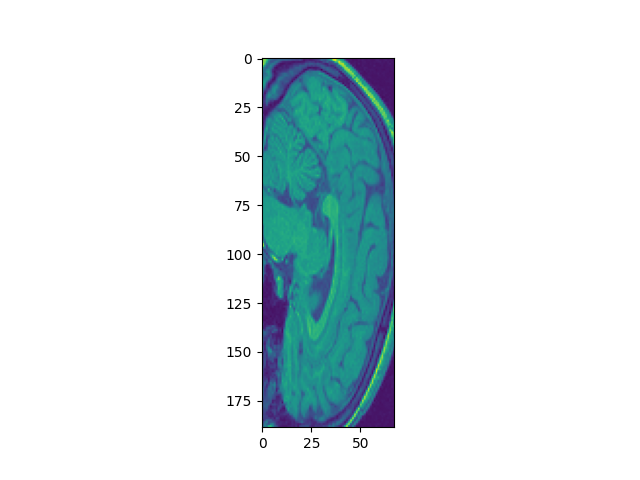

In [65]:
plt.figure()
plt.imshow(struct_arr[75])

The resolution along the vertical axis in many MRIs is not the same as along the horizontal axes. We can fix that by passing the aspect parameter to the imshow function:

<IPython.core.display.Javascript object>


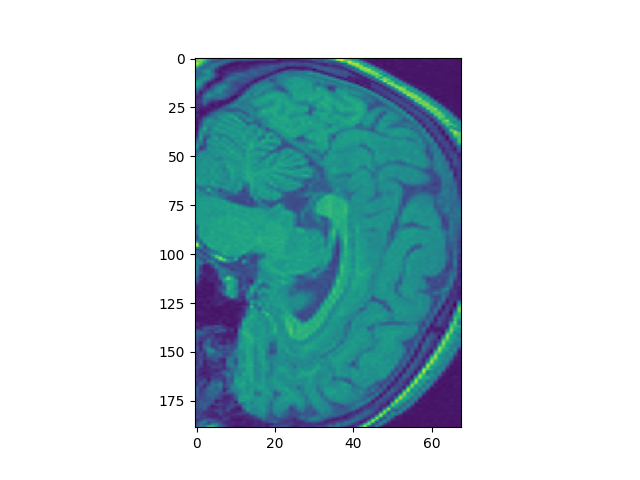

In [66]:
plt.figure()
plt.imshow(struct_arr[75], aspect=0.5)

we will just transpose the data and only look at the horizontal slices, which don’t need such fiddling.

<IPython.core.display.Javascript object>


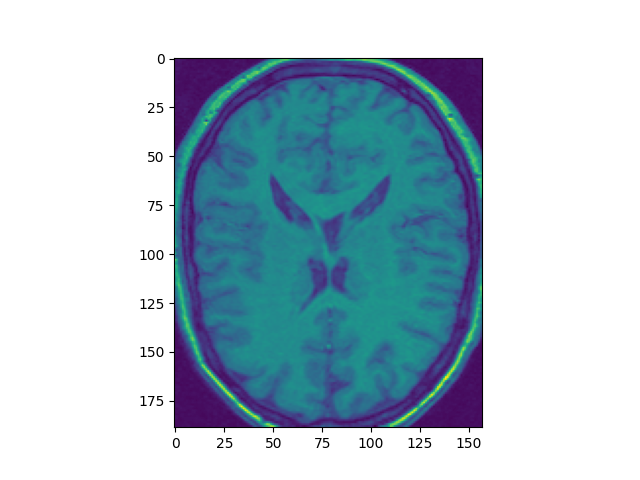

In [67]:
struct_arr2 = struct_arr.T

plt.figure()
plt.imshow(struct_arr2[34])

We can have a look on another slice:

<IPython.core.display.Javascript object>


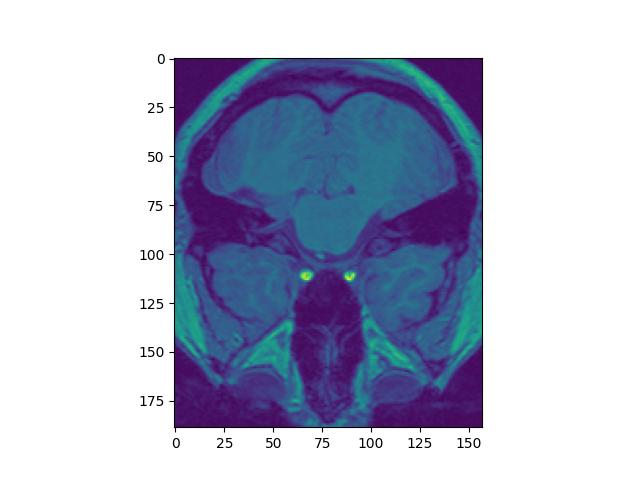

In [68]:
plt.figure()
plt.imshow(struct_arr2[5])

It’s quite easy to add 3D “scrolling” capabilities to the matplotlib viewer! This lets us explore 3D data within Python, minimizing the need to switch contexts between data exploration and data analysis.

We can use the `matplotlib` [event handler API], which lets us define actions to perform on the plot — including changing the plot’s data! — in response to particular key presses or mouse button clicks.

Let's bind the `J` and `K` on the keyboard to "previous slice" and "next slice":

In [69]:
def previous_slice(ax):
    """
    Go to the previous slice
    :param ax: input
    :return:
    """
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0] # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice():
    """
    Go to the next slice
    :param ax: input
    :return:
    """
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0] # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'left':
        previous_slice()
    elif event.key == 'right':
        next_slice()
    fig.canvas.draw()

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)


<IPython.core.display.Javascript object>


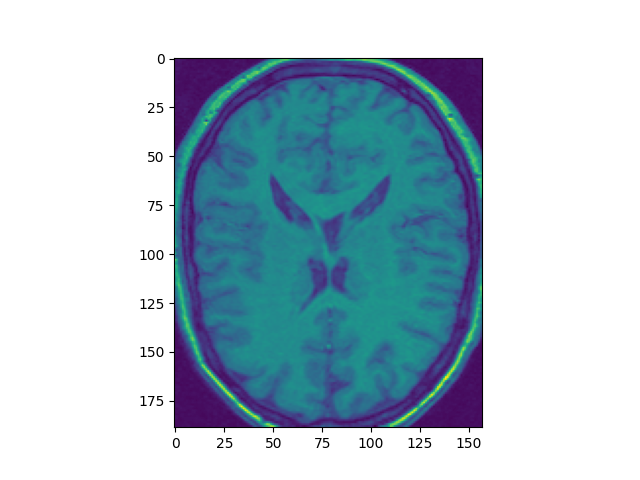

In [70]:
multi_slice_viewer(struct_arr2)
